# 1. Publications volume per city (in the EU, for a given year)

### Prerequisites

> This notebook assumes you have installed the `dimcli` library and are familiar with the [Getting Started](https://github.com/digital-science/dimensions-api-examples/blob/master/stable/1.%20Getting%20Started.ipynb) tutorial. 

In [8]:
import dimcli
dimcli.login()
dsl = dimcli.Dsl()

DimCli v0.4.3 - Succesfully connected to <https://app.dimensions.ai>


Let's also load the time library (for pacing the API queries) and pandas (for analysing the data) 

In [9]:
import time
import pandas as pd

## Approach 1: one query per day

We limit the number of results to a manageable size by querying for publications related to all cities in europe, for each day of the year. Eg. for a full year we would have 365 queries. Once we have collected all the data we can merge it and calculate the total sums per city.

The main problem with this approach is that....

#### 1. First let's try out the DSL query template we're gonna use later on

In [3]:
%%dsl_query
search publications
where type="article" and date="2019-04-03" and research_org_countries in ["AD","AL","AT","AX","BA","BE","BG","BY","CH","CZ","DE","DK","EE","ES","FI","FO","FR","GB","GG","GI","GR","HR","HU","IE","IM","IS","IT","JE","LI","LT","LU","LV","MC","MD","ME","MK","MT","NL","NO","PL","PT","RO","RS","RU","SE","SI","SJ","SK","SM","UA","VA"]
return research_org_cities limit 1000

Tot Publications:  2461
Returned Research_org_cities: 1000


<dimcli.Result object #4417980008: [('research_org_cities', 1000), ('_stats', 1)]>

#### 2. Manipulating the query results as a table

In [4]:
data = _['research_org_cities']
df1 = pd.DataFrame.from_dict(data)
df1.head()

The pandas library allows us to put all results into a big table.

Then we can then 'pivot' the table around the cities IDs and Names in order to calculate the total count of publications for each one of them.

In [7]:
df1.pivot_table(index=['id', 'name'], aggfunc=sum).sort_values(by=['count'], ascending=False)

,,count
id,name,
2643743,London,156
3117735,Madrid,75
2988507,Paris,75
3169070,Rome,71
524901,Moscow,62
2653941,Cambridge,60
3128760,Barcelona,52
2657896,Zürich,48
3173435,Milan,47


#### 3. Dates: here's a function that generates a list of dates for each day in a time frame

In [8]:
from datetime import datetime, date, timedelta
def date_range_from_strings(start_date=None, end_date=None):
    """
    From two string-dates formatted as YYYY-MM-DD
    Return a delta date_object which can be iterated on  
    <start_date> : => default: YESTERDAY
    <end_date> : => default: TODAY
    """
     # the following is redundant, added just as an example to simulate receiving a date-string
    if not start_date:
        yesterday = date.today() - timedelta(1)
        start_date = yesterday.strftime("%Y-%m-%d")
    if not end_date:
        end_date = date.today().strftime("%Y-%m-%d")
    d1 = datetime.strptime(start_date, '%Y-%m-%d').date()
    d2 = datetime.strptime(end_date, '%Y-%m-%d').date()
    delta = d2 - d1
    out = []
    for i in range(delta.days):
        step = d1 + timedelta(i)
        out += [step.strftime("%Y-%m-%d")]
    return out
# EG
start_date = "2019-04-01"
end_date = None # = today
print(date_range_from_strings(start_date, end_date))

['2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04', '2019-04-05', '2019-04-06', '2019-04-07', '2019-04-08', '2019-04-09', '2019-04-10', '2019-04-11', '2019-04-12', '2019-04-13', '2019-04-14', '2019-04-15', '2019-04-16', '2019-04-17']


#### 4. Define the list of countries we need, and the list of dates

Modify this as needed (see also https://www.geonames.org/countries/)

In [12]:
europe_countries = ["AD","AL","AT","AX","BA","BE","BG","BY","CH","CZ","DE","DK","EE","ES","FI","FO","FR","GB","GG","GI","GR","HR","HU","IE","IM","IS","IT","JE","LI","LT","LU","LV","MC","MD","ME","MK","MT","NL","NO","PL","PT","RO","RS","RU","SE","SI","SJ","SK","SM","UA","VA"]
europe_countries_string = ", ".join(["\"%s\"" % x for x in europe_countries])

start_date = "2018-01-01"
end_date = "2018-01-10"  # this is set to 10 days, so change it as needed
all_dates = date_range_from_strings(start_date, end_date)

#### 5. Set up the parametrized query loop 

In [11]:
q_template = """search publications
where type="article" and date="%s" and research_org_countries in [%s]
return research_org_cities limit 1000"""

In [15]:
df_master = pd.DataFrame()
for d in all_dates:
    query = q_template % (d, europe_countries_string)
    res = dsl.query(query, show_results=False)
    data = res['research_org_cities']
    if df_master.empty:
        df_master = pd.DataFrame.from_dict(data)
    else:
        df_temp = pd.DataFrame.from_dict(data)
        df_master = df_master.append(df_temp, sort=True)
    print("Master Dataset Rows:", len(df_master), type(df_master))
    time.sleep(1.5)
print("FINISHED!")    

Master Dataset Rows: 1000 <class 'pandas.core.frame.DataFrame'>
Master Dataset Rows: 2000 <class 'pandas.core.frame.DataFrame'>
Master Dataset Rows: 2363 <class 'pandas.core.frame.DataFrame'>
Master Dataset Rows: 2895 <class 'pandas.core.frame.DataFrame'>
Master Dataset Rows: 3471 <class 'pandas.core.frame.DataFrame'>
Master Dataset Rows: 3671 <class 'pandas.core.frame.DataFrame'>
Master Dataset Rows: 3835 <class 'pandas.core.frame.DataFrame'>
Master Dataset Rows: 4399 <class 'pandas.core.frame.DataFrame'>
Master Dataset Rows: 5023 <class 'pandas.core.frame.DataFrame'>
FINISHED!


#### 6. Let's group all results into a pivot table and display it

In [16]:
df_master = df_master.pivot_table(index=['id', 'name'], aggfunc=sum).sort_values(by=['count'], ascending=False)

In [20]:
len(df_master)

1907

In [18]:
# fix column names https://stackoverflow.com/questions/33290374/pandas-pivot-table-column-names
df_master.reset_index(inplace=True)

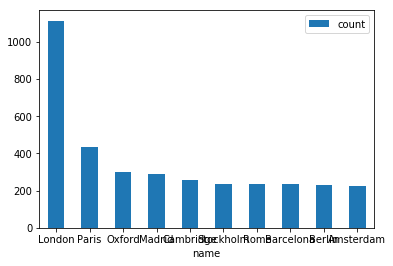

In [21]:
ax = df_master.head(10).plot.bar(x='name', rot=0,)

## Approach 2: one query per country

We limit the number of results to a manageable size by querying by country, for a full year, and extract all the cities information.

The main problem with this approach is that....

#### 1. First let's try out the DSL query template we're gonna use later on

In [10]:
%%dsl_query
search publications
where type="article" and year="2018" and research_org_countries in ["GB"]
return research_org_cities limit 1000

Tot Publications:  208832
Returned Research_org_cities: 1000


<dimcli.Result object #4576318128: [('research_org_cities', 1000), ('_stats', 1)]>

In [11]:
data = _['research_org_cities']
df1 = pd.DataFrame.from_dict(data)
df1.head()

,count,id,name
0,63968,2643743,London
1,16187,2653941,Cambridge
2,16087,2640729,Oxford
3,10707,2643123,Manchester
4,10415,2650225,Edinburgh


#### 2. Define the list of countries we need

Modify this as needed (see also https://www.geonames.org/countries/)

In [12]:
europe_countries = ["AD","AL","AT","AX","BA","BE","BG","BY","CH","CZ","DE","DK","EE","ES","FI","FO","FR","GB","GG","GI","GR","HR","HU","IE","IM","IS","IT","JE","LI","LT","LU","LV","MC","MD","ME","MK","MT","NL","NO","PL","PT","RO","RS","RU","SE","SI","SJ","SK","SM","UA","VA"]

#### 3. Set up the parametrized query loop 

In [13]:
q_template = """search publications
where type="article" and date="2018" and research_org_countries in ["%s"]
return research_org_cities limit 1000"""

In [14]:
df_master = pd.DataFrame()
for c in europe_countries:
    query = q_template % (c)
    res = dsl.query(query, show_results=False)
    data = res['research_org_cities']
    if data:
        if df_master.empty:
            df_master = pd.DataFrame.from_dict(data)
        else:
            df_temp = pd.DataFrame.from_dict(data)
            df_master = df_master.append(df_temp, sort=True)
    print("Country:", c, "Master Dataset Rows:", len(df_master), type(df_master))
    time.sleep(1.5)
print("FINISHED!")    

Country: AD Master Dataset Rows: 0 <class 'pandas.core.frame.DataFrame'>
Country: AL Master Dataset Rows: 6 <class 'pandas.core.frame.DataFrame'>
Country: AT Master Dataset Rows: 177 <class 'pandas.core.frame.DataFrame'>
Country: AX Master Dataset Rows: 177 <class 'pandas.core.frame.DataFrame'>
Country: BA Master Dataset Rows: 182 <class 'pandas.core.frame.DataFrame'>
Country: BE Master Dataset Rows: 482 <class 'pandas.core.frame.DataFrame'>
Country: BG Master Dataset Rows: 510 <class 'pandas.core.frame.DataFrame'>
Country: BY Master Dataset Rows: 581 <class 'pandas.core.frame.DataFrame'>
Country: CH Master Dataset Rows: 956 <class 'pandas.core.frame.DataFrame'>
Country: CZ Master Dataset Rows: 1093 <class 'pandas.core.frame.DataFrame'>
Country: DE Master Dataset Rows: 1682 <class 'pandas.core.frame.DataFrame'>
Country: DK Master Dataset Rows: 1970 <class 'pandas.core.frame.DataFrame'>
Country: EE Master Dataset Rows: 1977 <class 'pandas.core.frame.DataFrame'>
Country: ES Master Datase

In [22]:
df_master.to_csv(r'cities_data_raw_2019-04-21.csv')

In [16]:
df_master_merged = df_master.pivot_table(index=['id', 'name'], aggfunc=sum).sort_values(by=['count'], ascending=False)

In [17]:
len(df_master_merged)

1466

In [18]:
# fix column names https://stackoverflow.com/questions/33290374/pandas-pivot-table-column-names
df_master_merged.reset_index(inplace=True)

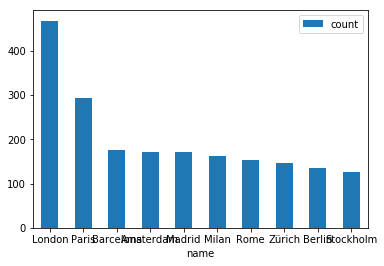

In [20]:
ax = df_master_merged.head(10).plot.bar(x='name', rot=0,)

In [22]:
df_master_merged.to_csv(r'cities_data_merged_2019-04-21.csv')